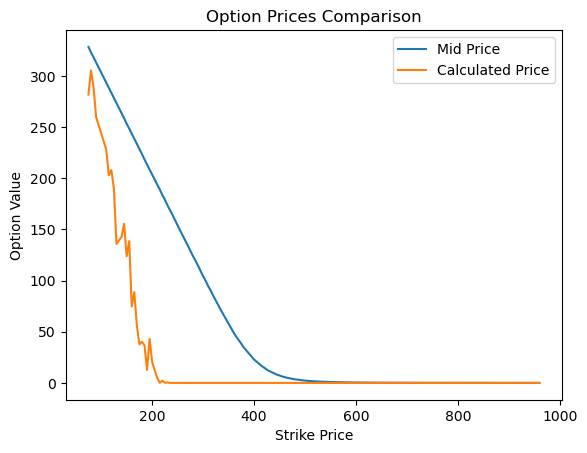

In [6]:
# Importing Libraries
import pandas as pd
import yfinance as yf
import numpy as np
import datetime as dt
import math
import matplotlib.pyplot as plt
from scipy.special import comb  # For stable combinations calculation

# Defining a function to compute combinations
def calculate_combinations(total_steps, current_step):
    return comb(total_steps, current_step, exact=False)

# Binomial option pricing function
def calculate_binomial_option_price(initial_stock_price, strike_price, time_to_maturity, risk_free_rate, volatility, steps, option_type='call'):
    step_time = time_to_maturity / steps
    up_factor = np.exp(volatility * np.sqrt(step_time))
    down_factor = np.exp(-volatility * np.sqrt(step_time))
    risk_neutral_probability = (np.exp(risk_free_rate * step_time) - down_factor) / (up_factor - down_factor)

    # Calculate option price at each node
    option_price = 0
    for current_step in range(steps + 1):
        node_probability = calculate_combinations(steps, current_step) * \
                           (risk_neutral_probability**current_step) * \
                           ((1 - risk_neutral_probability)**(steps - current_step))
        terminal_stock_price = initial_stock_price * (up_factor**current_step) * (down_factor**(steps - current_step))
        if option_type == 'call':
            option_price += max(terminal_stock_price - strike_price, 0) * node_probability
        elif option_type == 'put':
            option_price += max(strike_price - terminal_stock_price, 0) * node_probability
        else:
            raise ValueError("option_type must be 'call' or 'put'")

    return option_price * np.exp(-risk_free_rate * time_to_maturity)

# Retrieving option chain data from Yahoo Finance
def fetch_option_chain_data(ticker_symbol):
    stock_data = yf.Ticker(ticker_symbol)
    available_expirations = stock_data.options
    combined_option_data = []

    for expiration_date in available_expirations:
        option_chain = stock_data.option_chain(expiration_date)
        call_options = option_chain.calls
        call_options['OptionType'] = 'call'
        call_options['ExpirationDate'] = expiration_date
        put_options = option_chain.puts
        put_options['OptionType'] = 'put'
        put_options['ExpirationDate'] = expiration_date
        combined_option_data.append(pd.concat([call_options, put_options]))

    option_data_frame = pd.concat(combined_option_data)
    option_data_frame['MidPrice'] = (option_data_frame['ask'] + option_data_frame['bid']) / 2
    option_data_frame['TimeToMaturity'] = (pd.to_datetime(option_data_frame['ExpirationDate']) - pd.Timestamp.now()).dt.days / 365
    return option_data_frame[(option_data_frame['bid'] > 0) & (option_data_frame['ask'] > 0)]

# Main execution
option_data = fetch_option_chain_data('TSLA')
calculated_prices = []

for option in option_data.itertuples():
    try:
        option_price = calculate_binomial_option_price(
            option.lastPrice, option.strike, option.TimeToMaturity, 0.01, 0.5, 20, option.OptionType
        )
        calculated_prices.append(option_price)
    except Exception as error:
        calculated_prices.append(None)

option_data['CalculatedPrice'] = calculated_prices
option_data['PriceError'] = option_data['MidPrice'] - option_data['CalculatedPrice']

# Visualization for a specific expiration date and call options
specific_expiration = option_data[(option_data['ExpirationDate'] == option_data['ExpirationDate'].unique()[2]) & 
                                  (option_data['OptionType'] == 'call')]

plt.plot(specific_expiration['strike'], specific_expiration['MidPrice'], label='Mid Price')
plt.plot(specific_expiration['strike'], specific_expiration['CalculatedPrice'], label='Calculated Price')
plt.xlabel('Strike Price')
plt.ylabel('Option Value')
plt.legend()
plt.title('Option Prices Comparison')
plt.show()
